In [56]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Load the CIFAR-10 dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
image, label = cifar10[1900]  # Take the first image
image = image.unsqueeze(0)  # Add batch dimension

# Load a pretrained model (ResNet18 for example)
model = torchvision.models.efficientnet_b0(pretrained=True)
model.eval()

print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.features[-1][0]

SiLU(inplace=True)

In [73]:
layer_name = "layer4" 
conv_layer = model.features[-4] # model.layer2[0].conv1 

features = []

def hook_fn(module, input, output):
    features.append(output)

hook = conv_layer.register_forward_hook(hook_fn)

with torch.no_grad():
    _ = model(image)

hook.remove() 


In [74]:
feature_maps = features[0].squeeze(0).cpu().numpy()
feature_maps1 = np.array([
    (fm - fm.min()) / (fm.max() - fm.min() + 1e-5) * 255  # Scale to [0, 255]
    for fm in feature_maps
]).astype(np.uint8)
feature_maps.shape

(112, 2, 2)

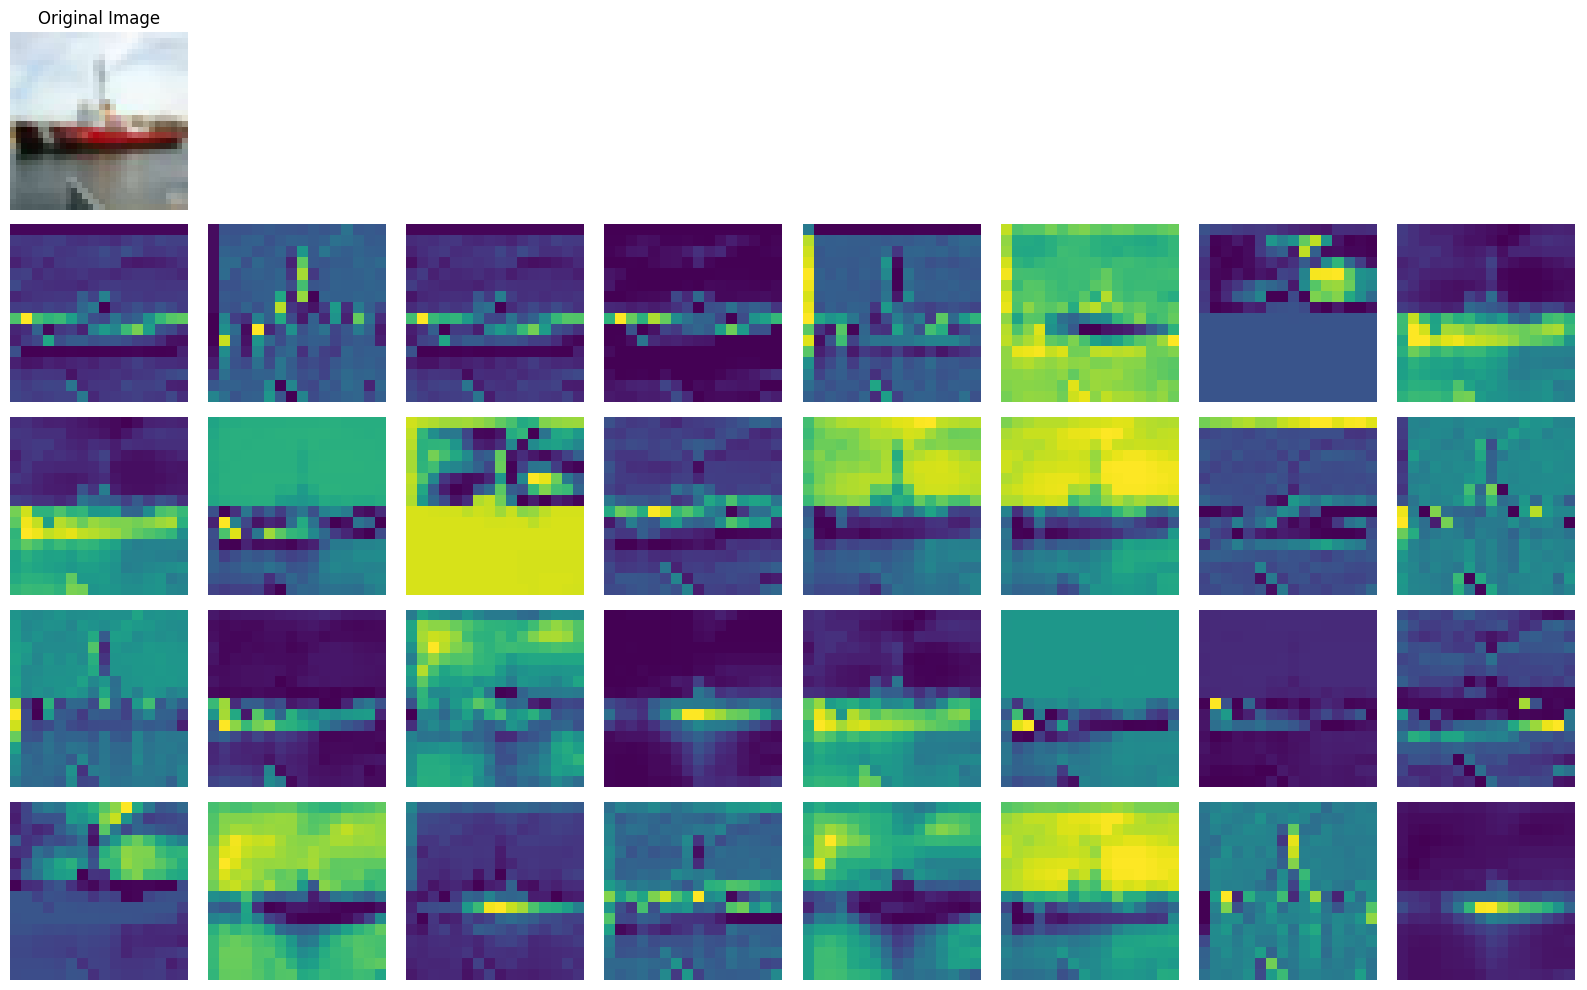

In [ ]:

# Convert feature maps to numpy
feature_maps = feature_maps1
# Define grid size
num_features = feature_maps.shape[0]  # Number of feature maps
cols = 8  # Columns in the grid
rows = (num_features // cols) + 1  # Extra row for the original image

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))

# Plot original image (without normalization for display)
original_image = cifar10.data[1900]  # Get original image from CIFAR-10 dataset
axes[0, 0].imshow(original_image)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

# Hide empty spots in the first row (except first column)
for j in range(1, cols):
    axes[0, j].axis("off")

for i in range(num_features):
    row = (i // cols) + 1  
    col = i % cols
    axes[row, col].imshow(feature_maps[i], cmap="viridis")
    axes[row, col].axis("off")

for i in range((num_features // cols + 1) * cols, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

/home/redix/Desktop/prml/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/redix/Desktop/prml/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


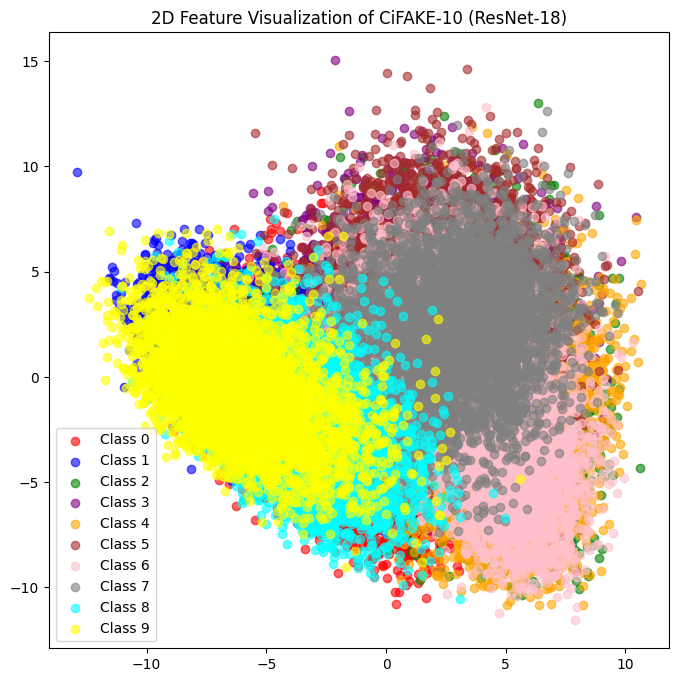

In [77]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the CiFAKE-10 dataset
transform = transforms.Compose([
    transforms.Resize(224),  # ResNet requires 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

cifake10_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(cifake10_dataset, batch_size=128, shuffle=True)

# Load Pretrained ResNet-18
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Identity()  # Remove the final classification layer to extract features
resnet18.to(device)
resnet18.eval()

# Extract Features
features_list, labels_list = [], []

with torch.no_grad():
    for images, labels in data_loader:
        images = images.to(device)
        features = resnet18(images)  # Extract high-level features (before final FC layer)
        features_list.append(features.cpu().numpy())
        labels_list.append(labels.numpy())

# Convert lists to numpy arrays
features = np.concatenate(features_list, axis=0)
labels = np.concatenate(labels_list, axis=0)

# Reduce Dimensionality to 2D
pca = PCA(n_components=2)  # Alternatively, use TSNE(n_components=2)
features_2d = pca.fit_transform(features)

# Plot Features
plt.figure(figsize=(8, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'yellow']
for i in range(10):  # Assuming 10 classes
    indices = labels == i
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], c=colors[i], label=f"Class {i}", alpha=0.6)

plt.legend()
plt.title("2D Feature Visualization of CiFAKE-10 (ResNet-18)")
plt.show()